In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn

import os
# Keep using Keras 2
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow_decision_forests as tfdf

In [2]:
df = pd.read_csv('answerList_data.csv')

def calculate_ttr(text):
    words = str(text).split()
    unique = set(words)
    ttr = len(unique) / len(words)
    return ttr

df['complexity'] = df['Answer.explanation'].apply(calculate_ttr)

In [44]:
students = ['Undergraduate_Student', 'Graduate_Student']
students_df = df[df['Worker.profession'].isin(students)]
others_df = df[~df['Worker.profession'].isin(students)]

students_df_gt = students_df[students_df['GroundTruth'] == 1]
students_df_ngt = students_df[students_df['GroundTruth'] == 0]

students_df_gt_train, students_df_gt_test = sklearn.model_selection.train_test_split(students_df_gt, test_size=0.2)
students_df_ngt_train, students_df_ngt_test = sklearn.model_selection.train_test_split(students_df_ngt, test_size=0.2)

students_df_train = pd.concat([students_df_gt_train, students_df_ngt_train], ignore_index=True).drop(columns=['TN', 'FN', 'TP', 'FP'])
students_df_test = pd.concat([students_df_gt_test, students_df_ngt_test], ignore_index=True).drop(columns=['TN', 'FN', 'TP', 'FP'])


In [45]:
label = "GroundTruth"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(students_df_train, label=label)
holdout_ds = tfdf.keras.pd_dataframe_to_tf_dataset(students_df_test, label=label)
complete_ds = tfdf.keras.pd_dataframe_to_tf_dataset(students_df, label=label)

In [46]:
tuner = tfdf.tuner.RandomSearch(num_trials=30, use_predefined_hps=True)
model_1 = tfdf.keras.RandomForestModel(tuner=tuner)


model_1.fit(train_ds, verbose=2)

Use /var/folders/36/2qtcl0jx6r94h6345h20r6880000gn/T/tmpc2ualy2t as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 

In [47]:
model_1.compile(metrics=['Precision', 'Recall'])
evaluation = model_1.evaluate(holdout_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 468ms/step - loss: 0.0000e+00 - precision: 1.0000 - recall: 0.4516

loss: 0.0000
precision: 1.0000
recall: 0.4516


In [48]:
predictions = model_1.predict(holdout_ds, verbose=2)

1/1 - 0s - 85ms/epoch - 85ms/step


In [49]:
students_df_test_eval = students_df_test.copy()
students_df_test_eval['Prediction'] = predictions
students_df_test_eval['PredictionRounded'] = predictions
students_df_test_eval.PredictionRounded = students_df_test_eval.PredictionRounded.round()
students_df_test_eval['RightPrediction'] = np.where(students_df_test_eval['PredictionRounded'] == students_df_test_eval['GroundTruth'], True, False)
students_df_test_eval['ExplanationLength'] = students_df_test_eval['Answer.explanation'].str.len()


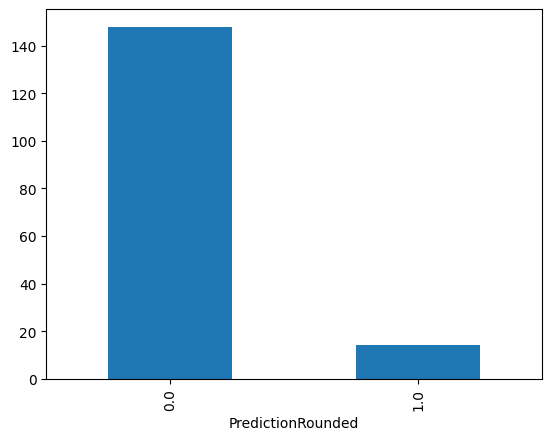

In [50]:
plot_3 = students_df_test_eval['PredictionRounded'].value_counts().plot(kind='bar')

In [51]:
holdout_df = students_df_test.copy()
others_df_shuffled = sklearn.utils.shuffle(others_df).drop(columns=['TP', 'TN', 'FP', 'FN'])

set_size = 10
evaluations = []

model_1.compile(metrics=['Precision', 'Recall'])

for i in range(1, 150):
    holdout_df = students_df_test.copy()
    holdout_df = pd.concat([holdout_df, others_df_shuffled.iloc[0:i*set_size]])
    ds = tfdf.keras.pd_dataframe_to_tf_dataset(holdout_df, label=label)
    evaluations.append(model_1.evaluate(ds, return_dict=True))

2/2 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - precision: 1.0000 - recall: 0.5110


In [52]:
print(evaluations)

[{'loss': 0.0, 'precision': 1.0, 'recall': 0.46875}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5142857432365417}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5142857432365417}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5277777910232544}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5526315569877625}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5365853905677795}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5365853905677795}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5348837375640869}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5333333611488342}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.54347825050354}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5531914830207825}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5306122303009033}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.529411792755127}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.529411792755127}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.529411792755127}, {'loss': 0.0, 'precision': 1.0, 'recall': 0.5094339847564697}, {'loss'

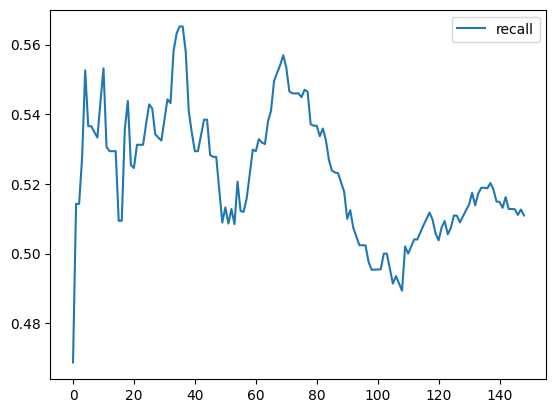

In [55]:
eval_df = df.from_records(evaluations)
plot_1 = eval_df.plot(kind='line', y='recall')

In [63]:
# Start of question 1.2

import sklearn.model_selection


others_df_shuffled = sklearn.utils.shuffle(others_df)
combined_df = students_df.copy()

results = []
trials = 5
size = 100
runs = 16

for i in range(0,runs):
    combined_df = students_df.copy()
    combined_df = pd.concat([combined_df, others_df_shuffled.iloc[0:i*size]])
    combined_df_gt = combined_df[combined_df['GroundTruth'] == 1]
    combined_df_ngt = combined_df[combined_df['GroundTruth'] == 0]

    combined_df_gt_train, combined_df_gt_holdout = sklearn.model_selection.train_test_split(combined_df_gt, test_size=0.2)
    combined_df_ngt_train, combined_df_ngt_holdout = sklearn.model_selection.train_test_split(combined_df_ngt, test_size=0.2)

    combined_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([combined_df_gt_train, combined_df_ngt_train]).drop(columns=['TP', 'TN', 'FP', 'FN']), label=label)
    combined_holdout_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([combined_df_gt_holdout, combined_df_ngt_holdout]).drop(columns=['TP', 'TN', 'FP', 'FN']), label=label)

    combined_tuner = tfdf.tuner.RandomSearch(num_trials=trials, use_predefined_hps=True)
    model = tfdf.keras.RandomForestModel(tuner=combined_tuner)
    model.fit(combined_train_ds, verbose=2)

    model.compile(['Precision', 'Recall'])
    results.append(model.evaluate(combined_holdout_ds, return_dict=True))


Use /var/folders/36/2qtcl0jx6r94h6345h20r6880000gn/T/tmp7_7q93pw as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Answer.ID': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'FailingMethod': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Question.ID': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, 'Answer.duration': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Answer.confidence': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Answer.difficulty': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'Answer.option': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Answer.order': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, 'Answer.explanation': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'Code.LOC': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, 'Code.complexity': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, 'Worker.ID': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Worker.score': <tf.Tensor 

In [64]:
results

[{'loss': 0.0, 'precision': 1.0, 'recall': 0.35483869910240173},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.4285714328289032},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.2631579041481018},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.4285714328289032},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.5652173757553101},
 {'loss': 0.0, 'precision': 0.9032257795333862, 'recall': 0.5600000023841858},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.7454545497894287},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.6779661178588867},
 {'loss': 0.0, 'precision': 0.9821428656578064, 'recall': 0.8730158805847168},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.8656716346740723},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.8611111044883728},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.8684210777282715},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.925000011920929},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.9176470637321472},
 {'loss': 0.0, 'precision': 1.0, 'recall': 0.9550561904907227},
 {'loss': 

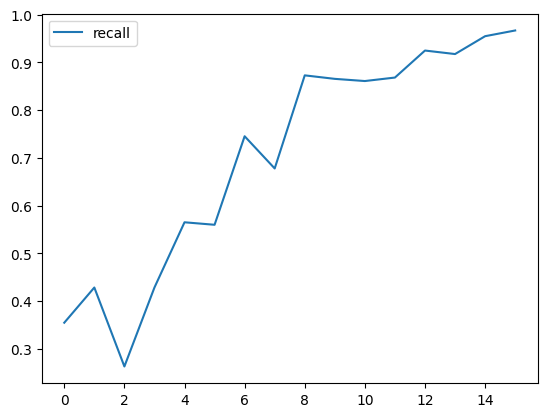

In [66]:
training_eval_df = df.from_records(results)
plot_2 = training_eval_df.plot(kind='line', y='recall')

In [90]:
# Start of Task 2
import requests
import json

url = "http://localhost:11434/api/generate"
headers = {
    "Content-Type": "application/json"
}
model_deepseek = "deepseek-r1:7b"
model_llama = "llama3.2:1b"
data = {
    "model": model_llama,
    "prompt": "",
    "stream": False
}

explanations_df = df[(df['FailingMethod'] == 'HIT01_8') & (df['TP'] == 1)]
ground_truth = 'The specification states, that the method "DateTimeZone()" accepts a minutes offset value in the range of -59 to 59 inlcusive. The method checks if this value, stored as "minutesOffset", is within these bounds on line 279, but incorrectly throws an "IllegalArgumentException" for any minutes offset less than zero instead of less than -59. To fix the issue and satisfy the specification, the conditional on line 279 should check for "minutesOffset < -59" instead.'

In [100]:
# Start of loop here

prompt = "### Task:\nYour are a professional software developer. Please consolidate the following failure explanations into a single explanation, that contains all the information required to understand and fix the bug. The explanation should be succinct and without redundant information.\n\n### Output:\nReturn a JSON with a single field consolidated_explanation that contains the generated explanation.\n\n### Input:\nHere is a list of explanations that should be consolidated:\n\n"

explanation_list = explanations_df['Answer.explanation'].to_list()

task2_runs = 31
responses = []

for i in range(task2_runs):
    if i >= len(explanation_list):
        break
    temp_prompt = prompt + '\n\n'.join(explanation_list[0:i])

    data["prompt"] = temp_prompt

    response = requests.post(url, headers=headers, data=json.dumps(data))

    if (response.status_code == 200):
        responses.append(json.loads(response.text)["response"])
    else:
        # print("Error: ", response.status_code, response.text)
        pass

In [92]:
print(temp_prompt)

### Task:
Your are a professional software developer. Please consolidate the following failure explanations into a single explanation, that contains all the information required to understand and fix the bug. The explanation should be succinct and without redundant information.

### Output:
Return a JSON with a single field consolidated_explanation that contains the generated explanation.

### Input:
Here is a list of explanations that should be consolidated:

Minutes are set to -15; which is less then 0 and it throws illegal arg exception


In [102]:
print(responses[-1])

### Consolidated Explanation:

The `MinutesOutOfRangeException` is thrown because the `minutesOffset` parameter is not validated correctly. The code checks if the `minutesOffset` is greater than 59, but this does not account for negative minutes or hours.

Specifically, the issue lies on line 279 where the condition `if (minutesOffset < -59 || minutesOffset > 59)` is used to check if the input is valid. However, this condition throws an exception when the `minutesOffset` value is less than 0 because it checks for values between 0 and 59 instead of below -59.

The correct validation should be `if (minutesOffset < -59)`. This ensures that negative minutes or hours are also considered invalid inputs.

To fix this issue, the code should be modified to use the corrected condition on line 279. Additionally, the variable `minutesOffSet` is defined as an `unsigned int` and passed as a parameter when calling the method.

Here's the updated code with the consolidated explanation:

```java
if (mi